In [1]:
# Multiple horizons MTM analysis
include("C:\\Users\\Federico\\Documents\\GitHub\\pysical_locomotion\\analysis\\behavior\\analysis_fixtures.jl")
include("C:\\Users\\Federico\\Documents\\GitHub\\pysical_locomotion\\analysis\\behavior\\analysis_visuals.jl")

import jcontrol as jc
using Printf

@Info (Main):  Loaded 1021 trials 
  ╰──────────────────────────────────────────────── 
                      Thu, 26 May 2022 08:38:09 
@Info (Main):  After tortuosity analysis, discarded 9.109% of trials | 928 
  │                trials left 
  ╰──────────────────────────────────────────────── 
                      Thu, 26 May 2022 08:38:14 


  Activating project at `C:\Users\Federico\Documents\GitHub\pysical_locomotion\analysis\behavior`


## Load data

In [2]:
function make_palette(x)
    return range(HSL(217, .64, .55), stop=HSL(320, .73, .78), length=length(x))
end


function get_startstop(solution, curve)
    start = findfirst(solution.s .>= curve.s0)
    stop = findfirst(solution.s .>= curve.sf)
    stop = isnothing(stop) ? argmax(solution.s) : stop

    complete = solution.s[stop] > (curve.sf - 1)
    return start, stop, complete
end



get_startstop (generic function with 1 method)

In [8]:



globalsolution = load_global_solution()

# path = "/Users/federicoclaudi/Dropbox (UCL)/Rotation_vte/Locomotion/analysis/behavior/horizons_mtm_sims"
path = "D:\\Dropbox (UCL)\\Rotation_vte\\Locomotion\\analysis\\behavior\\horizons_mtm_sims"

# load individual solutions
files = sort(glob("*.csv", path), lt=natural)

curves_solutions = Dict(
    1=>Dict{String,Any}(), 2=>Dict{String,Any}(), 3=>Dict{String,Any}(), 4=>Dict{String,Any}()
)


s2curvidx = Dict(
    0=>1, 45=>2, 98=>3, 15=>4
)

for file in files[2:end]
    fname = string(splitext(basename(file))[1])
    s = fname[5] != '.' ? parse(Int, fname[4:5]) : 0
    curve = s2curvidx[s]

    if curve == 1
        horizon = fname[24:27]
    elseif curve == 4 
        horizon = fname[26:29]
    else
        horizon = fname[25:28]
    end

    sol  = df2sol(DataFrame(CSV.File(file)))
    length(sol.x) == 0 && continue
    curves_solutions[curve][horizon] = sol
end


# get how many simulations per curve we would expect
planned_horizons = horizons = vcat(collect(.08:.01:.38), collect(.38:.02:.54), collect(.5:.05:1.2))
n_planned_horizons = length(planned_horizons)

for (k,v) in pairs(curves_solutions)
    println("Curve $k, loaded $(length(v))/($n_planned_horizons)")
end

Curve 4, loaded 53/(55)
Curve 2, loaded 53/(55)
Curve 3, loaded 53/(55)
Curve 1, loaded 52/(55)


## Plots

### XY trajectory

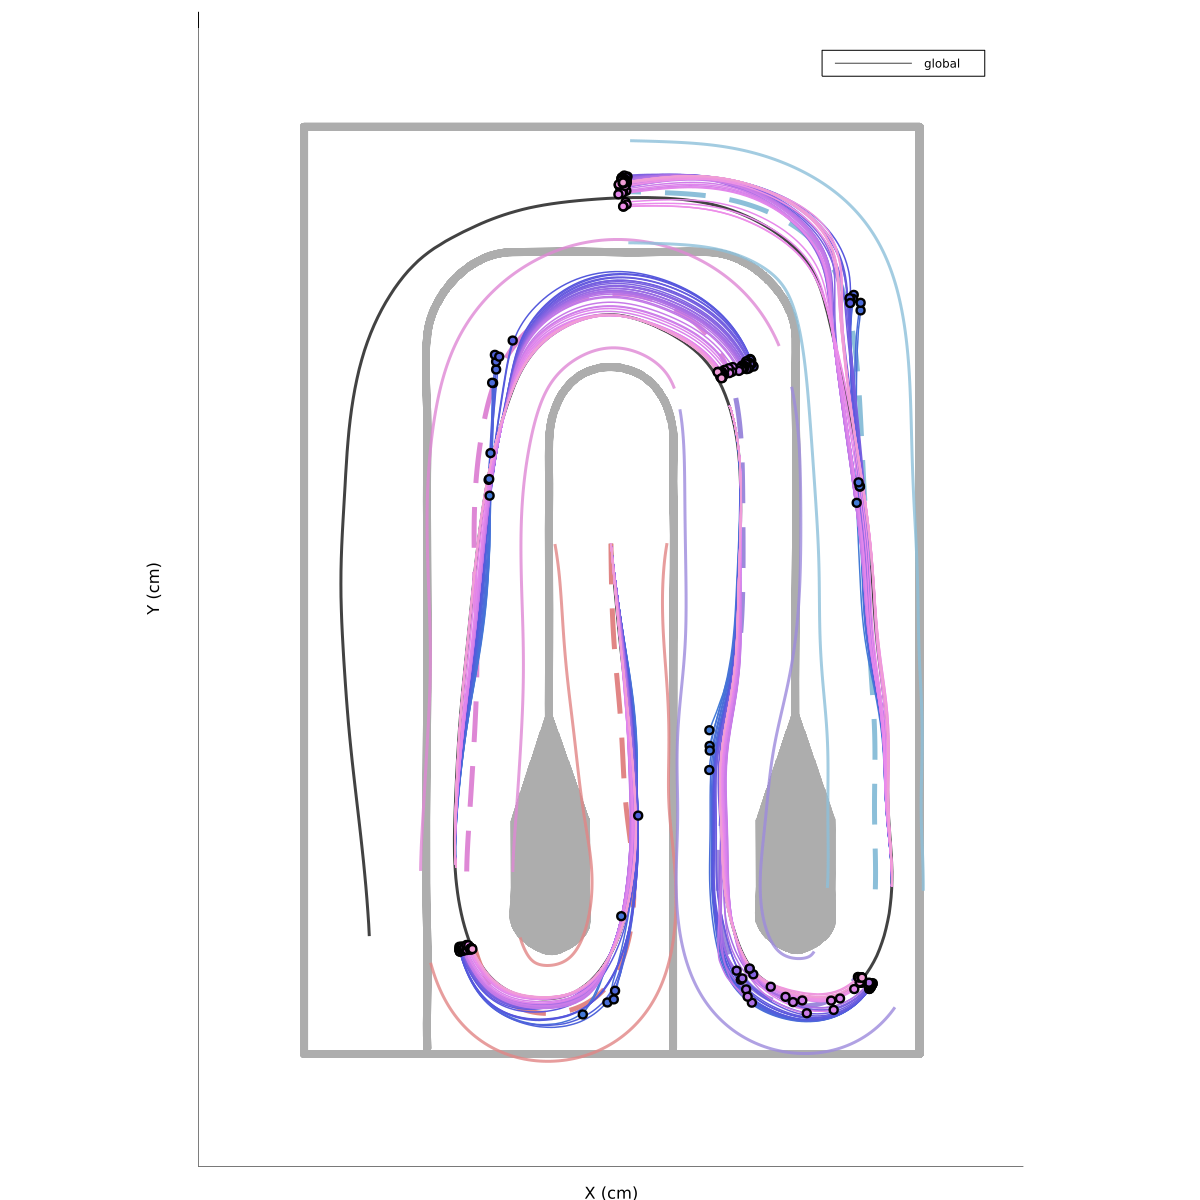

In [9]:
# plot XY traj
_horizons = vcat(collect(.08:.01:.38), collect(.38:.02:.54), collect(.5:.05:1.2))
_colors = make_palette(_horizons)
colors = Dict(string(@sprintf("%.2f", h))=>c for (h,c) in zip(_horizons, _colors))


plt = draw(:arena)

# draw!.(trials[1:200])
plot!(globalsolution.x, globalsolution.y, label="global", color=grey_darker, lw=3)
plot!(; grid=false, xticks=[], yticks=[])

for k in 1:4
    # get data
    curve = curves[k]
    curve_sols = curves_solutions[k]
    horizons = sort(collect(keys(curve_sols)))

    # draw curve
    track = jc.trim(FULLTRACK, curve.s0, curve.sf-curve.s0)
    draw!(track, color=curves_colors[k], Δp=50, alpha=1)

    # plot XY traj
    for horizon in horizons
        color = colors[horizon]
        solution = curve_sols[horizon]
        length(solution.x) == 0 && continue
        start, stop, complete = get_startstop(solution, curve)
        plot!(solution.x[start:stop], solution.y[start:stop], label=nothing, color=color, lw=1.5) 
    end

    for horizon in horizons
        color = colors[horizon]
        solution = curve_sols[horizon]
        start, stop, complete = get_startstop(solution, curve)
        scatter!([solution.x[stop]], [solution.y[stop]], label=nothing, color=color, ms=5)
    end
end

savefig(joinpath(PLOTS_FOLDER, "horizons_XY.svg"))
plt

### durations plot

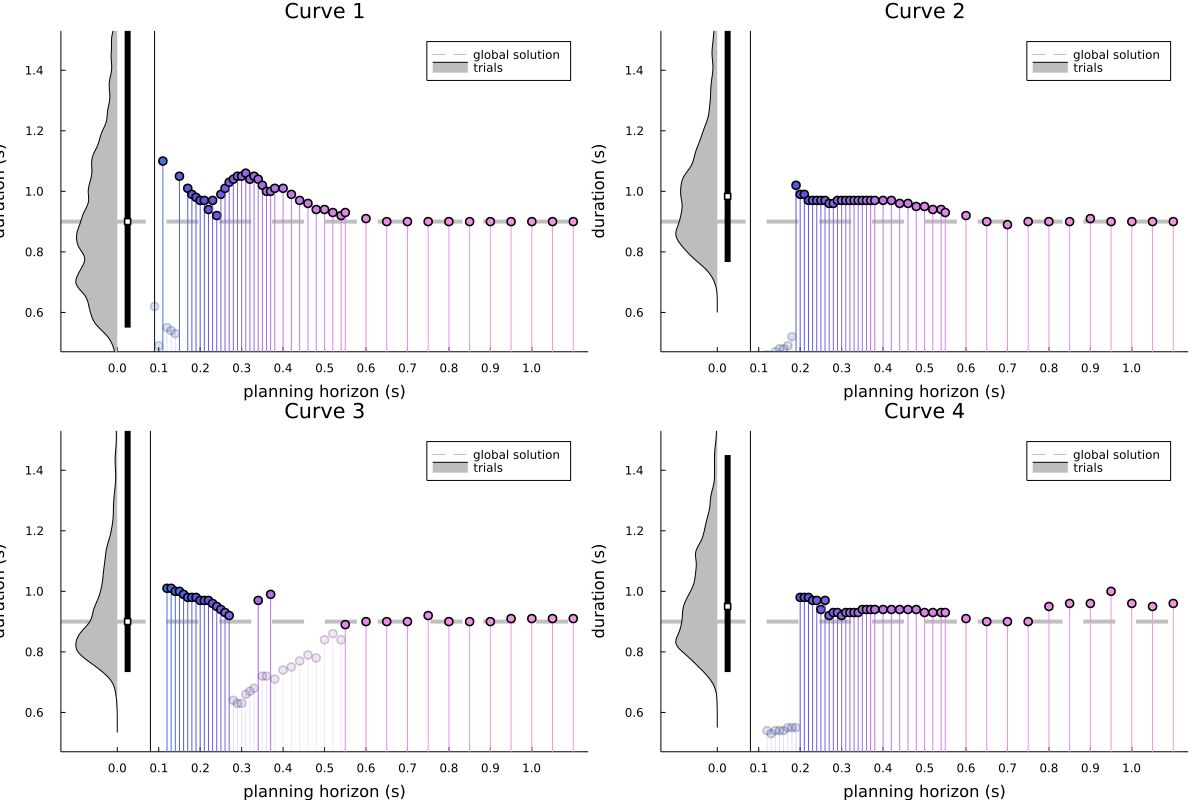

In [10]:
plots = []

Δt=.01  # step size used for simulations
T0 = 0
for k in 1:4
    # get data
    curve = curves[k]
    curve_sols = curves_solutions[k]
    horizons = sort(collect(keys(curves_solutions[k])))
    length(horizons) == 0 && continue

    plt = plot(; xlabel="planning horizon (s)", ylabel="duration (s)", ylim=[0.5, 1.5], xlim=[-.1, 1.1], title="Curve $k", xticks=0.0:.1:1)

    # plot duration for globalsolution
    start, stop, complete = get_startstop(globalsolution, curve)
    hline!([(stop-start)*globalsolution.δt], lw=4, color="black", alpha=.25, ls=:dash, label="global solution")

    # mark min/max horizons
    vline!(
        [parse(Float64, horizons[1]), parse(Float64, horizons[end])], color="black", label=nothing
    )

    # plot duration of each sim
    for horizon in horizons
        color = colors[horizon]
        solution = curve_sols[horizon]
        start, stop, complete = get_startstop(solution, curve)
        alpha = complete ? 1.0 : 0.2

        duration = (stop-start)  * Δt

        h = parse(Float64, horizon)
        # vline!([h], lw=.5, color="black", label=nothing)
        plot!(plt, [h, h], [T0, duration], label=nothing, color=color, alpha=alpha, lw=1)
        scatter!(plt, [h], [duration], label=nothing, color=color, alpha=alpha, ms=5)
    end


    # plot KDE with durations of each trial
    trial_durations = []
    for trial in trials
        _, _, start, stop = get_curve_indices(trial, curve.s0, curve.sf)
        push!(trial_durations, (stop-start) / 60)
    end
    B = kde(Vector{Float64}(trial_durations); bandwidth=.025)
    plot!(
        -B.density ./ max(B.density...) .* .1 , B.x;
        color="black",
        fillalpha=1,
        fillcolor=grey,
        fillrange=zeros(length(B.density)),
        label="trials"
    )
    low, med, high = percentile(trial_durations, [2.5, 50, 97.5])
    plot!(
        [0.025, 0.025], [low, high], lw=6, color="black", alpha=1, label=nothing
    )
    scatter!([0.025], [med], label=nothing, color="white", ms=3, shape=:rect)


    push!(plots, plt)
end


fig = plot(plots...; grid=false, link=:all, size=(1200, 800))
savefig(joinpath(PLOTS_FOLDER, "horizons_duration.svg"))

fig

### mean distance plot

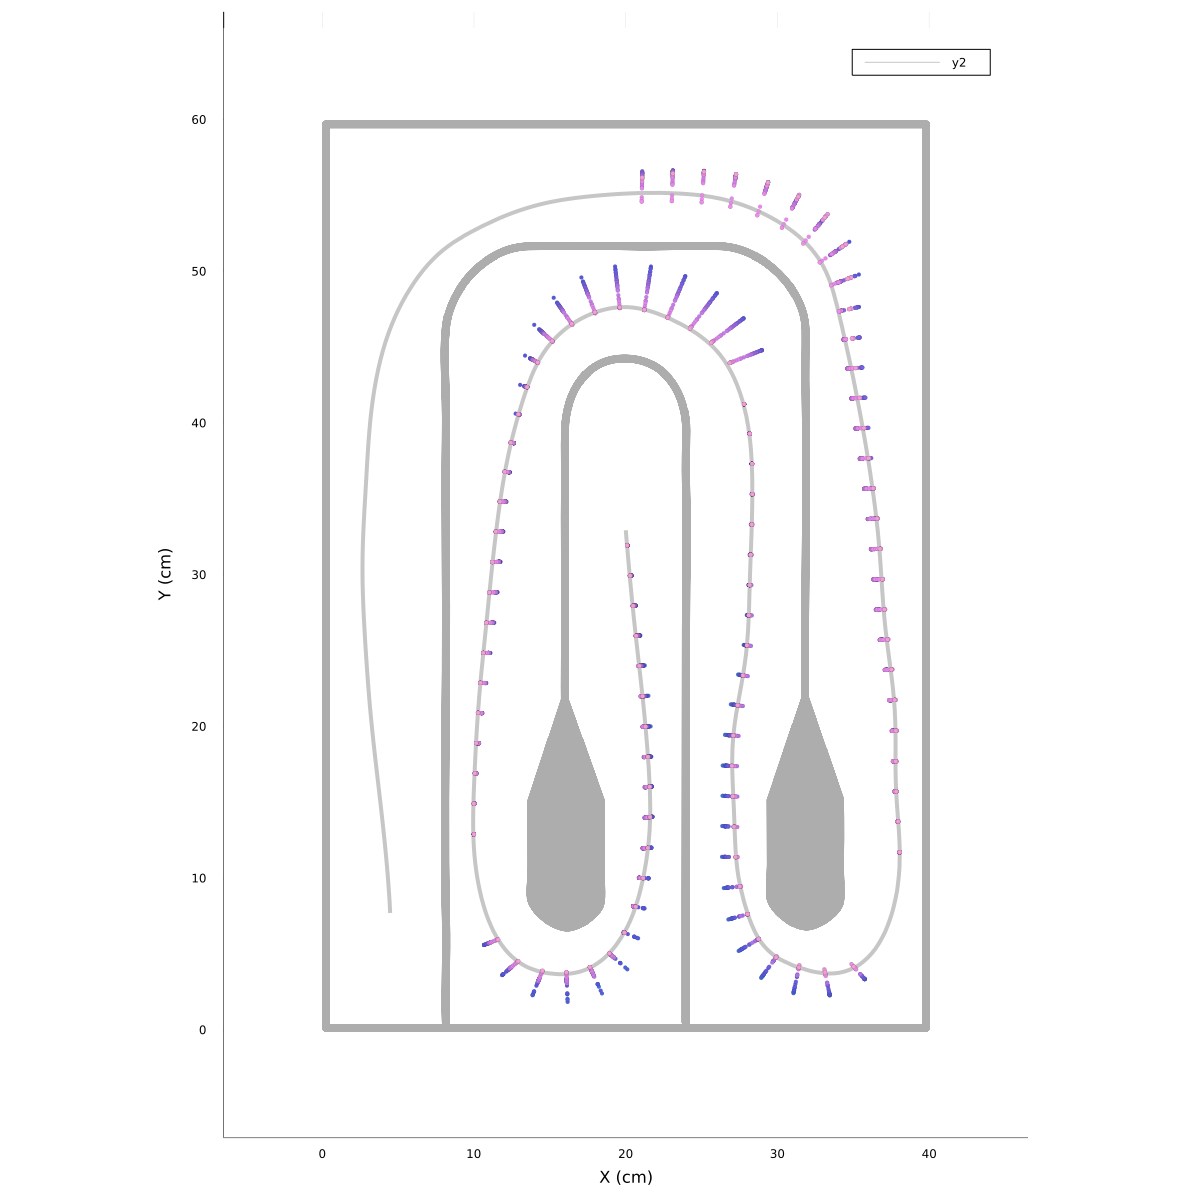

In [11]:
δs = 2

fig = draw(:arena)

plot!(
    globalsolution.x, globalsolution.y, color=grey_darker, lw=4, alpha=.3
)

distances = []
for k in 1:4
    plt = plot() 

    # get data
    curve = curves[k]
    curve_sols = curves_solutions[k]
    horizons = sort(collect(keys(curves_solutions[k])))
    length(horizons) == 0 && continue
    curve_distances = Dict{String, Vector{Float64}}(h=>[-100.0] for h in horizons)


    S = collect(curve.s0+2:2:curve.sf)

    gs_x = get_solution_variable_at_s_values(globalsolution, curve.s0+1, curve.sf, δs, :x)
    gs_y = get_solution_variable_at_s_values(globalsolution, curve.s0+1, curve.sf, δs, :y)
    # scatter!(fig, gs_x, gs_y, label=nothing, color="black", ms=4)

    # mark each solution
    for horizon in horizons
        color = colors[horizon]
        solution = curve_sols[horizon]
        
        start, stop, complete = get_startstop(solution, curve)
        complete || continue

        x = get_solution_variable_at_s_values(solution, curve.s0+1, curve.sf, δs, :x)
        y = get_solution_variable_at_s_values(solution, curve.s0+1, curve.sf, δs, :y)

        if any(isnan.(x)) || any(isnan.(y))
            throw("caca")
        end

        # keep distances
        curve_distances[horizon] = sqrt.((gs_x .- x).^2 + (gs_y .- y).^2)

        scatter!(fig, x, y, label=nothing, color=color, ms=2.5, msw=0.0)
    end
    push!(distances, curve_distances)
end

savefig(joinpath(PLOTS_FOLDER, "horizons_XY_scatter.svg"))
fig

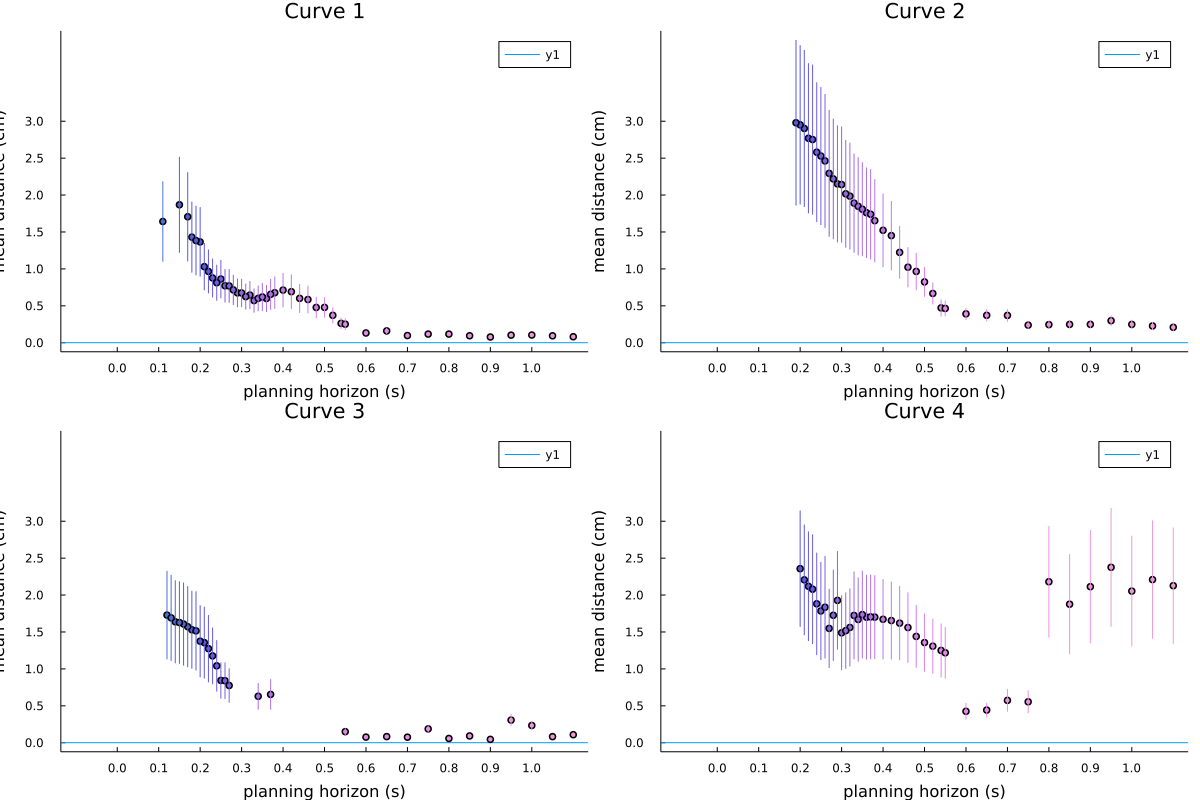

In [18]:
plots = []
for k in 1:4
    plt = plot(; xlabel="planning horizon (s)", ylabel="mean distance (cm)", xlim=[-.1, 1.1], title="Curve $k", xticks=0.0:.1:1, yticks=0:.5:3.0)
    hline!([0])
    
    # get data
    curve = curves[k]
    curve_distances = distances[k]
    length(curve_distances) == 0 && continue
    horizons = sort(collect(keys(curve_distances)))
    length(horizons) == 0 && continue

    for (h, d) in pairs(curve_distances)
        d[1] == -100.0 && continue
        # d̄ = mean(d)
        d̄ = max(d...)
        low, high = -std(d) + d̄, std(d) + d̄

        color = colors[h]
        h = parse(Float64, h)

        scatter!(plt, [h], [d̄], label=nothing, color=color, ms=4)
        plot!(plt, [h, h], [low, high], label=nothing, color=color, lw=1)
    end

    push!(plots, plt)
end

fig = plot(plots...; grid=false, link=:all, size=(1200, 800))
savefig(joinpath(PLOTS_FOLDER, "horizons_distances.svg"))
fig

plot the total progression along the track for each curve/simulation

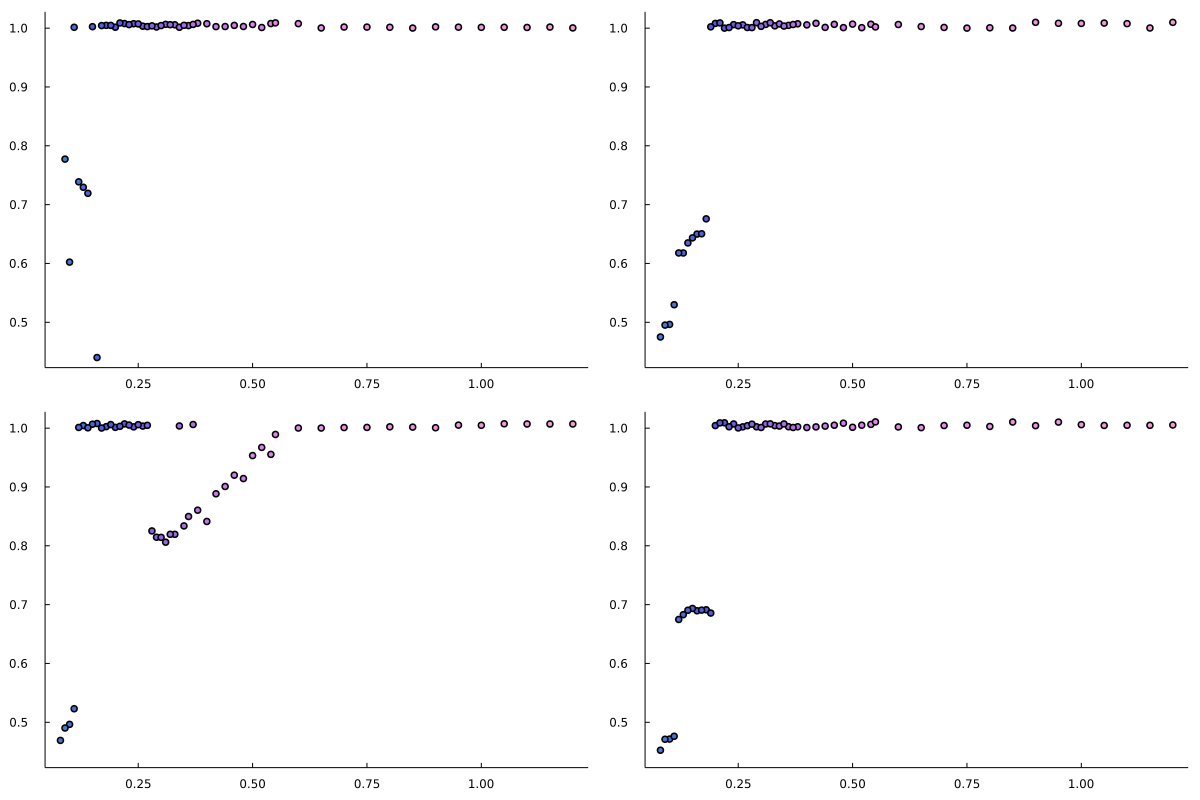

In [30]:
plots = []


distances = []
for k in 1:4
    plt = plot() 

    # get data
    curve = curves[k]
    curve_sols = curves_solutions[k]
    horizons = sort(collect(keys(curves_solutions[k])))

    for (h, sol) in pairs(curve_sols)
        start, stop, complete = get_startstop(sol, curve)
        color = colors[h]
        s = (sol.s[stop]-curve.s0)/(curve.sf-curve.s0)
        scatter!([parse(Float64, h)], [s], color=color, label=nothing)

    end
    # hline!([curve.sf], lw=2, label="curve end")

    push!(plots, plt)
end

plot(plots...; grid=false, link=:all, size=(1200, 800))

In [26]:
curves[1]

Curve(0.0, 32.0, 40.0, 1.5, "first", 20.0, -1, ComparisonPoint s=0.0 @ xy=(20.0, 32.9), ComparisonPoint s=32.0 @ xy=(17.1, 2.9), ComparisonPoint s=40.0 @ xy=(11.3, 6.9))